# 전력 변압기 오일 온도 예측 프로젝트
# Power Transformer Oil Temperature Prediction Project

## << 문제 정의 / Problem Definition >>

주어진 ETDataset을 사용하여 전력 변압기의 **오일 온도(OT, Oil Temperature)**를 예측하는 문제를 풉니다.
Using the ETDataset, we solve the problem of predicting the **Oil Temperature (OT)** of power transformers.

주어진 데이터는 총 3개의 CSV 파일입니다. 각 CSV 파일에 대한 설명은 아래에 기술되어 있습니다.
The given data consists of 3 CSV files. Descriptions for each file are provided below.

### 평가 지표 / Evaluation Metric
- **RMSE (Root Mean Squared Error)**: 각 시간대별로 예측한 OT와 실제 OT 사이의 오차
- **목표 / Target**: RMSE < 0.5

### 데이터 설명 / Data Description

#### 1. train.csv (학습 데이터 / Training Data)
- **기간 / Period**: 2016년 7월 1일 0시 ~ 2017년 12월 31일 23시 45분
- **컬럼 / Columns**: date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT
- **특성 설명 / Feature Description**:
  - **HUFL**: High UseFul Load (고부하 유효 전력)
  - **HULL**: High UseLess Load (고부하 무효 전력)
  - **MUFL**: Middle UseFul Load (중부하 유효 전력)
  - **MULL**: Middle UseLess Load (중부하 무효 전력)
  - **LUFL**: Low UseFul Load (저부하 유효 전력)
  - **LULL**: Low UseLess Load (저부하 무효 전력)
  - **OT**: Oil Temperature (오일 온도) - **타겟 변수 / Target Variable**

#### 2. test.csv (테스트 데이터 / Test Data)
- **기간 / Period**: 2018년 1월 1일 0시 ~ 2018년 6월 30일 23시 45분
- **컬럼 / Columns**: date, HUFL, HULL, MUFL, MULL, LUFL, LULL (OT 제외)

#### 3. submission.csv (제출 파일 / Submission File)
- 예측한 OT 값을 기록하는 파일

### 접근 방법 / Approach
1. **Feature Engineering**: 시간 특성, 순환 특성, 지연 특성, 롤링 특성 생성
2. **LightGBM**: 테이블 데이터에 적합한 그래디언트 부스팅 모델
3. **GRU (Deep Learning)**: 시계열 패턴 학습을 위한 순환 신경망
4. **Ensemble**: 모델 성능 기반 가중 평균

In [12]:
!pip install optuna


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [13]:
# ============================================================
# 라이브러리 임포트 / Library Imports
# ============================================================
# 이 셀에서는 프로젝트에 필요한 모든 라이브러리를 불러옵니다.
# This cell imports all necessary libraries for the project.

# ------------------------------------------------------------
# 기본 라이브러리 / Standard Libraries
# ------------------------------------------------------------
import pandas as pd  # 데이터 처리 / Data manipulation
import numpy as np   # 수치 연산 / Numerical operations
import matplotlib.pyplot as plt  # 시각화 / Visualization
import seaborn as sns  # 고급 시각화 / Advanced visualization

# ------------------------------------------------------------
# 진행률 표시 / Progress Display
# ------------------------------------------------------------
from tqdm.auto import tqdm  # 학습 진행률 표시 / Training progress bar

# ------------------------------------------------------------
# 머신러닝 라이브러리 / Machine Learning Libraries
# ------------------------------------------------------------
import lightgbm as lgb  # LightGBM: 그래디언트 부스팅 모델 / Gradient boosting model

from sklearn.model_selection import train_test_split  # 데이터 분할 / Data splitting
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # 스케일링 / Scaling
from sklearn.metrics import mean_squared_error  # 평가 지표 / Evaluation metric

# ------------------------------------------------------------
# 딥러닝 라이브러리 (PyTorch) / Deep Learning Libraries (PyTorch)
# ------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau  # 🔧 추가: 학습률 스케줄러 / LR scheduler

# ------------------------------------------------------------
# 하이퍼파라미터 최적화 / Hyperparameter Optimization
# ------------------------------------------------------------
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ------------------------------------------------------------
# 유틸리티 / Utilities
# ------------------------------------------------------------
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 환경 설정 / Environment Configuration
# ============================================================

# 디바이스 설정: GPU 사용 가능 시 CUDA, 아니면 CPU
# Device configuration: Use CUDA if GPU available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

# 재현성을 위한 시드 설정 / Set seed for reproducibility
# 동일한 결과를 얻기 위해 모든 난수 생성기에 시드 설정
# Set seed for all random number generators to ensure consistent results
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    # 🔧 추가: CUDA 결정적 연산 / Deterministic CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"🎲 Random seed set: {RANDOM_SEED}")

# 데이터는 15분 간격으로 기록됨 / Data is recorded at 15-minute intervals
# 1시간 = 4 타임스텝, 1일 = 96 타임스텝
# 1 hour = 4 timesteps, 1 day = 96 timesteps
INTERVALS_PER_HOUR = 4
INTERVALS_PER_DAY = 24 * INTERVALS_PER_HOUR  # 96

# 시각화 설정 / Visualization settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# 기본 데이터 경로 설정 (로컬 환경용) / Default data path (for local environment)
DATA_PATH = 'dataset/'
print(f"📁 Default data path: {DATA_PATH}")

🖥️ Using device: cuda
🎲 Random seed set: 42
📁 Default data path: dataset/


In [14]:
# Google Colab 환경 설정 | Google Colab environment setup
# 로컬 환경에서는 이 셀을 건너뛰세요 | Skip this cell in local environment

# Colab 환경 확인 | Check if running in Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Colab에서 데이터 경로 설정 | Set data path for Colab
    # 아래 경로를 자신의 Google Drive 경로에 맞게 수정하세요
    # Modify the path below to match your Google Drive path
    DATA_PATH = '/content/drive/MyDrive/your_path_here/dataset/'
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    # 로컬 환경 | Local environment
    DATA_PATH = 'dataset/'
    IN_COLAB = False
    print("Running in local environment")

print(f"Data path: {DATA_PATH}")

Running in local environment
Data path: dataset/


### Q1. train.csv와 test.csv를 불러오고, 각 데이터의 shape을 출력하세요. 또한, 결측치가 있는지 확인하고 각 열별로 결측치의 개수를 출력하세요.

In [15]:
# A1. 데이터 로드 및 결측치 확인 | Load data and check missing values

# CSV 파일 로드 | Load CSV files
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')

# 데이터 shape 출력 | Print data shapes
print("=" * 50)
print("[Data Shape | 데이터 Shape]")
print("=" * 50)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 결측치 확인 | Check missing values
print("\n" + "=" * 50)
print("[Train Missing Values | Train 결측치]")
print("=" * 50)
print(train.isnull().sum())

print("\n" + "=" * 50)
print("[Test Missing Values | Test 결측치]")
print("=" * 50)
print(test.isnull().sum())

# 결측치 요약 | Missing values summary
print("\n" + "=" * 50)
print("[Summary | 요약]")
print("=" * 50)
print(f"Total missing in train: {train.isnull().sum().sum()}")
print(f"Total missing in test: {test.isnull().sum().sum()}")

[Data Shape | 데이터 Shape]
Train shape: (52704, 8)
Test shape: (16976, 7)

[Train Missing Values | Train 결측치]
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

[Test Missing Values | Test 결측치]
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
dtype: int64

[Summary | 요약]
Total missing in train: 0
Total missing in test: 0


### Q2. 'date' 열을 사용하여 'hour', 'dayofweek', 'month' 특성을 생성하고, 'hour'와 'dayofweek'에 대해 sin과 cos 변환을 적용하여 cyclic feature를 만드세요. 주기를 결정하는건 자유롭게 정하셔도 됩니다!

In [16]:
# ============================================================
# A2. 순환 특성 생성 / Create Cyclic Features
# ============================================================
# 시간 관련 특성은 순환적 특성을 가지므로 sin/cos 변환을 적용합니다.
# Time-related features have cyclic nature, so we apply sin/cos transformation.
# 
# 🔧 개선: minute 특성 추가 (15분 간격 데이터이므로 유용)
# 🔧 Improvement: Add minute feature (useful for 15-min interval data)

def create_time_features(df):
    """
    시간 관련 특성을 생성합니다.
    Create time-related features.
    
    Args:
        df: date 열이 있는 DataFrame / DataFrame with 'date' column
    
    Returns:
        시간 특성이 추가된 DataFrame / DataFrame with time features added
    """
    df = df.copy()
    
    # date 열을 datetime으로 변환 / Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # ------------------------------------------------------------
    # 기본 시간 특성 추출 / Extract basic time features
    # ------------------------------------------------------------
    df['hour'] = df['date'].dt.hour          # 시간 (0-23) / Hour
    df['minute'] = df['date'].dt.minute      # 🔧 추가: 분 (0, 15, 30, 45) / Minute
    df['dayofweek'] = df['date'].dt.dayofweek  # 요일 (0=월요일) / Day of week
    df['month'] = df['date'].dt.month        # 월 (1-12) / Month
    df['dayofyear'] = df['date'].dt.dayofyear  # 🔧 추가: 연중 일수 / Day of year
    
    # ------------------------------------------------------------
    # 순환 변환 적용 (sin/cos) / Apply cyclic transformation
    # ------------------------------------------------------------
    # 순환 특성은 주기의 끝과 시작이 연결되어야 함
    # Cyclic features should connect end to start of period
    # 예: 23시와 0시는 가까워야 함 / e.g., 23:00 and 00:00 should be close
    
    # hour: 24시간 주기 / 24-hour cycle
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # 🔧 추가: minute: 60분 주기 / 60-minute cycle
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    
    # dayofweek: 7일 주기 / 7-day cycle
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # month: 12개월 주기 / 12-month cycle
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # 🔧 추가: dayofyear: 365일 주기 (계절성 포착)
    # 🔧 Added: dayofyear: 365-day cycle (captures seasonality)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    return df

# Train과 Test 데이터에 시간 특성 적용 / Apply time features to train and test
train = create_time_features(train)
test = create_time_features(test)

print("=" * 60)
print("[Cyclic Features Created | 생성된 순환 특성]")
print("=" * 60)
print("기본 특성 / Basic features:")
print("  - hour, minute, dayofweek, month, dayofyear")
print("\n순환 변환 특성 / Cyclic transformed features:")
print("  - hour_sin, hour_cos (24시간 주기 / 24-hour cycle)")
print("  - minute_sin, minute_cos (60분 주기 / 60-minute cycle)")
print("  - dayofweek_sin, dayofweek_cos (7일 주기 / 7-day cycle)")
print("  - month_sin, month_cos (12개월 주기 / 12-month cycle)")
print("  - dayofyear_sin, dayofyear_cos (365일 주기 / 365-day cycle)")
print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")

[Cyclic Features Created | 생성된 순환 특성]
기본 특성 / Basic features:
  - hour, minute, dayofweek, month, dayofyear

순환 변환 특성 / Cyclic transformed features:
  - hour_sin, hour_cos (24시간 주기 / 24-hour cycle)
  - minute_sin, minute_cos (60분 주기 / 60-minute cycle)
  - dayofweek_sin, dayofweek_cos (7일 주기 / 7-day cycle)
  - month_sin, month_cos (12개월 주기 / 12-month cycle)
  - dayofyear_sin, dayofyear_cos (365일 주기 / 365-day cycle)

Train shape: (52704, 23)
Test shape: (16976, 22)


### Q3. 'OT' 열에 대해 1시간 전, 2시간 전, 3시간 전의 값을 나타내는 lag 특성을 생성하세요.

In [17]:
# ============================================================
# A3. 지연 특성 및 롤링 특성 생성 / Create Lag and Rolling Features
# ============================================================
# 시계열 예측에서 과거 값은 미래 예측에 중요한 정보를 제공합니다.
# In time series forecasting, past values provide important information for future predictions.
#
# 🔧 개선: 롤링 통계량 (평균, 표준편차) 추가
# 🔧 Improvement: Add rolling statistics (mean, std)

def create_lag_features(df, target_col='OT', lags_hours=[1, 2, 3, 6, 12, 24]):
    """
    지연 특성을 생성합니다.
    Create lag features.
    
    Args:
        df: 대상 DataFrame / Target DataFrame
        target_col: 타겟 열 이름 / Target column name
        lags_hours: 지연 시간 리스트 (시간 단위) / List of lag hours
    
    Returns:
        지연 특성이 추가된 DataFrame / DataFrame with lag features
    """
    df = df.copy()
    
    for lag_h in lags_hours:
        shift_steps = lag_h * INTERVALS_PER_HOUR
        df[f'{target_col}_lag_{lag_h}h'] = df[target_col].shift(shift_steps)
    
    return df

def create_rolling_features(df, target_col='OT', windows_hours=[1, 3, 6, 12, 24]):
    """
    롤링 통계량 특성을 생성합니다.
    Create rolling statistics features.
    
    롤링 특성은 시계열의 트렌드와 변동성을 포착합니다.
    Rolling features capture trends and volatility in time series.
    
    Args:
        df: 대상 DataFrame / Target DataFrame
        target_col: 타겟 열 이름 / Target column name
        windows_hours: 윈도우 크기 리스트 (시간 단위) / List of window sizes in hours
    
    Returns:
        롤링 특성이 추가된 DataFrame / DataFrame with rolling features
    """
    df = df.copy()
    
    for window_h in windows_hours:
        window_steps = window_h * INTERVALS_PER_HOUR
        
        # 롤링 평균: 지정된 윈도우 내 평균값 (트렌드 포착)
        # Rolling mean: Average within window (captures trend)
        df[f'{target_col}_rolling_mean_{window_h}h'] = (
            df[target_col].shift(1).rolling(window=window_steps, min_periods=1).mean()
        )
        
        # 롤링 표준편차: 지정된 윈도우 내 변동성 (변동성 포착)
        # Rolling std: Volatility within window (captures volatility)
        df[f'{target_col}_rolling_std_{window_h}h'] = (
            df[target_col].shift(1).rolling(window=window_steps, min_periods=1).std()
        )
    
    return df

# ------------------------------------------------------------
# Train 데이터에 지연 및 롤링 특성 적용
# Apply lag and rolling features to train data
# ------------------------------------------------------------

# 지연 특성: 1시간, 2시간, 3시간, 6시간, 12시간, 24시간 전
# Lag features: 1h, 2h, 3h, 6h, 12h, 24h ago
lag_hours = [1, 2, 3, 6, 12, 24]
train = create_lag_features(train, 'OT', lag_hours)

# 롤링 특성: 1시간, 3시간, 6시간, 12시간, 24시간 윈도우
# Rolling features: 1h, 3h, 6h, 12h, 24h windows
rolling_hours = [1, 3, 6, 12, 24]
train = create_rolling_features(train, 'OT', rolling_hours)

# 결측치 개수 확인 / Check NaN count
max_nan_rows = INTERVALS_PER_HOUR * max(lag_hours)  # 24시간 지연으로 인한 최대 NaN

print("=" * 60)
print("[Lag & Rolling Features Created | 지연 및 롤링 특성 생성]")
print("=" * 60)

print("\n📊 지연 특성 / Lag Features:")
for lag_h in lag_hours:
    shift_steps = lag_h * INTERVALS_PER_HOUR
    print(f"  - OT_lag_{lag_h}h: OT value from {lag_h} hour(s) ago (shift={shift_steps})")

print("\n📈 롤링 특성 / Rolling Features:")
for window_h in rolling_hours:
    print(f"  - OT_rolling_mean_{window_h}h: {window_h}시간 이동 평균 / {window_h}h rolling mean")
    print(f"  - OT_rolling_std_{window_h}h: {window_h}시간 이동 표준편차 / {window_h}h rolling std")

print(f"\n⚠️ 지연/롤링으로 인한 NaN 행: 최대 {max_nan_rows}개")
print(f"⚠️ NaN rows from lag/rolling: up to {max_nan_rows}")
print(f"\nTrain shape: {train.shape}")

[Lag & Rolling Features Created | 지연 및 롤링 특성 생성]

📊 지연 특성 / Lag Features:
  - OT_lag_1h: OT value from 1 hour(s) ago (shift=4)
  - OT_lag_2h: OT value from 2 hour(s) ago (shift=8)
  - OT_lag_3h: OT value from 3 hour(s) ago (shift=12)
  - OT_lag_6h: OT value from 6 hour(s) ago (shift=24)
  - OT_lag_12h: OT value from 12 hour(s) ago (shift=48)
  - OT_lag_24h: OT value from 24 hour(s) ago (shift=96)

📈 롤링 특성 / Rolling Features:
  - OT_rolling_mean_1h: 1시간 이동 평균 / 1h rolling mean
  - OT_rolling_std_1h: 1시간 이동 표준편차 / 1h rolling std
  - OT_rolling_mean_3h: 3시간 이동 평균 / 3h rolling mean
  - OT_rolling_std_3h: 3시간 이동 표준편차 / 3h rolling std
  - OT_rolling_mean_6h: 6시간 이동 평균 / 6h rolling mean
  - OT_rolling_std_6h: 6시간 이동 표준편차 / 6h rolling std
  - OT_rolling_mean_12h: 12시간 이동 평균 / 12h rolling mean
  - OT_rolling_std_12h: 12시간 이동 표준편차 / 12h rolling std
  - OT_rolling_mean_24h: 24시간 이동 평균 / 24h rolling mean
  - OT_rolling_std_24h: 24시간 이동 표준편차 / 24h rolling std

⚠️ 지연/롤링으로 인한 NaN 행: 최대 96개
⚠️ NaN row

### Q4. 불필요한 열인 'date'를 제거하고, 특성 행렬 X와 목표 변수 y를 생성하여 데이터를 시간 순서에 따라 3:1 비율로 훈련 세트와 검증 세트로 분할하세요.

In [18]:
# ============================================================
# A4. 데이터 준비 및 분할 / Prepare and Split Data
# ============================================================
# 특성 행렬 X와 목표 변수 y를 생성하고 시간 순서에 따라 분할합니다.
# Create feature matrix X and target variable y, then split by time order.
#
# 🔧 시계열 데이터는 반드시 시간 순서로 분할해야 합니다 (shuffle=False)
# 🔧 Time series data must be split by time order (shuffle=False)
# 미래 데이터를 사용한 예측은 데이터 누수(data leakage)를 일으킵니다.
# Using future data for prediction causes data leakage.

# date 열 제거 / Remove date column
train_processed = train.drop(columns=['date'])

# NaN 값이 있는 행 제거 (지연/롤링 특성으로 인해 발생)
# Drop rows with NaN values (caused by lag/rolling features)
initial_len = len(train_processed)
train_processed = train_processed.dropna()
dropped_rows = initial_len - len(train_processed)

print("=" * 60)
print("[Data Preparation | 데이터 준비]")
print("=" * 60)
print(f"⚠️ NaN 행 제거 / Dropped NaN rows: {dropped_rows}")
print(f"   남은 데이터 / Remaining data: {len(train_processed)}")

# ------------------------------------------------------------
# 특성 행렬 X와 목표 변수 y 생성
# Create feature matrix X and target variable y
# ------------------------------------------------------------
y = train_processed['OT']
X = train_processed.drop(columns=['OT'])

# 특성 목록 확인 / Check feature list
print(f"\n📋 총 특성 수 / Total features: {len(X.columns)}")
print(f"   컬럼 목록 / Column list:\n   {list(X.columns)}")

# ------------------------------------------------------------
# 시간 순서에 따라 3:1 비율로 분할 (시계열이므로 shuffle=False)
# Split by time order in 3:1 ratio (no shuffle for time series)
# ------------------------------------------------------------
# ⚠️ 중요: 시계열 데이터는 절대 셔플하면 안됩니다!
# ⚠️ Important: Never shuffle time series data!
# 이유: 미래 정보가 학습에 누출되어 과적합 발생
# Reason: Future information leaks into training, causing overfitting

train_ratio = 0.75
split_idx = int(len(X) * train_ratio)

X_train = X.iloc[:split_idx].copy()
X_val = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_val = y.iloc[split_idx:].copy()

# 분할 날짜 확인 (원본 train에서 확인)
# Check split date (from original train data)
train_dates = train.dropna()['date']
split_date = train_dates.iloc[split_idx]

print("\n" + "=" * 60)
print("[Data Split | 데이터 분할]")
print("=" * 60)
print(f"📅 분할 기준 날짜 / Split date: {split_date}")
print(f"📊 학습 세트 / Training set: {len(X_train)} samples ({train_ratio * 100:.0f}%)")
print(f"📊 검증 세트 / Validation set: {len(X_val)} samples ({(1 - train_ratio) * 100:.0f}%)")

# 타겟 변수 통계 확인 / Check target variable statistics
print("\n[Target Variable Statistics | 타겟 변수 통계]")
print(f"  Train OT - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"  Valid OT - Mean: {y_val.mean():.4f}, Std: {y_val.std():.4f}")

[Data Preparation | 데이터 준비]
⚠️ NaN 행 제거 / Dropped NaN rows: 96
   남은 데이터 / Remaining data: 52608

📋 총 특성 수 / Total features: 37
   컬럼 목록 / Column list:
   ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'hour', 'minute', 'dayofweek', 'month', 'dayofyear', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'OT_lag_1h', 'OT_lag_2h', 'OT_lag_3h', 'OT_lag_6h', 'OT_lag_12h', 'OT_lag_24h', 'OT_rolling_mean_1h', 'OT_rolling_std_1h', 'OT_rolling_mean_3h', 'OT_rolling_std_3h', 'OT_rolling_mean_6h', 'OT_rolling_std_6h', 'OT_rolling_mean_12h', 'OT_rolling_std_12h', 'OT_rolling_mean_24h', 'OT_rolling_std_24h']



[Data Split | 데이터 분할]
📅 분할 기준 날짜 / Split date: 2017-08-17 00:00:00
📊 학습 세트 / Training set: 39456 samples (75%)
📊 검증 세트 / Validation set: 13152 samples (25%)

[Target Variable Statistics | 타겟 변수 통계]
  Train OT - Mean: 17.4328, Std: 8.6987
  Valid OT - Mean: 9.3889, Std: 4.4728


### Q5. LightGBM을 사용하여 모델을 학습한 후, 검증 세트에 대한 RMSE를 계산하세요. 하이퍼파라미터는 num_leaves=31, n_estimators=100, learning_rate=0.05로 설정하세요.

In [19]:
# A5. LightGBM 기준 모델 학습 | Train LightGBM baseline model

# 지정된 하이퍼파라미터로 모델 생성 | Create model with specified hyperparameters
lgb_model = lgb.LGBMRegressor(
    num_leaves=31,
    n_estimators=100,
    learning_rate=0.05,
    random_state=RANDOM_SEED,
    verbosity=-1
)

# 모델 학습 | Train model
lgb_model.fit(X_train, y_train)

# 예측 및 RMSE 계산 | Predict and calculate RMSE
y_pred = lgb_model.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred))

print("[LightGBM Baseline Results | LightGBM 기준 결과]")
print(f"Hyperparameters: num_leaves=31, n_estimators=100, learning_rate=0.05")
print(f"Validation RMSE: {rmse_baseline:.6f}")

[LightGBM Baseline Results | LightGBM 기준 결과]
Hyperparameters: num_leaves=31, n_estimators=100, learning_rate=0.05
Validation RMSE: 0.492754


### Q6. optuna를 사용하여 LightGBM의 하이퍼파라미터를 튜닝하고, 최적의 모델을 이용하여 검증 세트에 대한 RMSE를 계산하세요. RMSE를 0.5 이하로 낮추는 것을 목표로 합니다.

In [20]:
# A6. Optuna 하이퍼파라미터 튜닝 | Optuna hyperparameter tuning

def objective(trial):
    """
    Optuna 목적 함수 | Optuna objective function
    LightGBM 하이퍼파라미터 최적화 | LightGBM hyperparameter optimization
    """
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_SEED,
        'verbosity': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Optuna 스터디 생성 및 최적화 | Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nBest Trial:")
trial = study.best_trial
print(f"  RMSE: {trial.value:.6f}")
print("  Best Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 최적의 하이퍼파라미터로 모델 재학습 | Retrain model with best hyperparameters
best_params = trial.params
best_params['random_state'] = RANDOM_SEED
best_params['verbosity'] = -1

best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_val)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))
print(f"\nOptuna Tuned LightGBM Validation RMSE: {rmse_best:.6f}")

if rmse_best < 0.5:
    print("✓ Target achieved: RMSE < 0.5 | 목표 달성: RMSE < 0.5")
else:
    print("✗ Target not achieved: RMSE >= 0.5 | 목표 미달성: RMSE >= 0.5")

  0%|          | 0/50 [00:00<?, ?it/s]


Best Trial:
  RMSE: 0.478923
  Best Params: 
    num_leaves: 57
    n_estimators: 431
    learning_rate: 0.023127949210369526
    max_depth: 10
    min_child_samples: 74
    subsample: 0.5988493732614941
    colsample_bytree: 0.8634224031152277
    reg_alpha: 9.512828002964834
    reg_lambda: 0.004409980194820293

Optuna Tuned LightGBM Validation RMSE: 0.478923
✓ Target achieved: RMSE < 0.5 | 목표 달성: RMSE < 0.5


### Q7. PyTorch를 사용하여 GRU 기반의 시계열 예측 모델을 구축하기 위해, OT 열을 정규화(Min-Max Scaling)하고 시계열 형태로 변환하세요. 입력 시퀀스의 길이는 24시간으로 설정하세요.

In [21]:
# A7. GRU 데이터 준비 | Prepare data for GRU

# 시퀀스 길이: 24시간 = 96 타임 스텝 (15분 간격)
# Sequence length: 24 hours = 96 time steps (15-minute intervals)
SEQUENCE_LENGTH = 24 * INTERVALS_PER_HOUR  # 96

# 원본 train 데이터를 다시 로드하여 GRU용으로 사용
# Reload original train data for GRU (to avoid conflicts with modified data)
train_gru = pd.read_csv(DATA_PATH + 'train.csv')
train_gru['date'] = pd.to_datetime(train_gru['date'])

# 시간 특성 추출 | Extract time features
train_gru['hour'] = train_gru['date'].dt.hour
train_gru['dayofweek'] = train_gru['date'].dt.dayofweek
train_gru['month'] = train_gru['date'].dt.month

# 순환 변환 | Cyclic transformation
train_gru['hour_sin'] = np.sin(2 * np.pi * train_gru['hour'] / 24)
train_gru['hour_cos'] = np.cos(2 * np.pi * train_gru['hour'] / 24)
train_gru['dayofweek_sin'] = np.sin(2 * np.pi * train_gru['dayofweek'] / 7)
train_gru['dayofweek_cos'] = np.cos(2 * np.pi * train_gru['dayofweek'] / 7)
train_gru['month_sin'] = np.sin(2 * np.pi * train_gru['month'] / 12)
train_gru['month_cos'] = np.cos(2 * np.pi * train_gru['month'] / 12)

# 특성 열 선택 (date 제외, OT는 마지막에)
# Select feature columns (exclude date, OT at the end)
feature_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL',
                'hour', 'dayofweek', 'month',
                'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
                'month_sin', 'month_cos', 'OT']

data = train_gru[feature_cols].values

# MinMaxScaler로 정규화 | Normalize with MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 생성 | Create sequences
X_sequences = []
y_sequences = []

for i in range(SEQUENCE_LENGTH, len(data_scaled)):
    X_sequences.append(data_scaled[i - SEQUENCE_LENGTH:i])  # 입력: 24시간 시퀀스
    y_sequences.append(data_scaled[i, -1])  # 출력: 현재 OT 값 (마지막 열)

X_array = np.array(X_sequences)
y_array = np.array(y_sequences)

# 시간 순서에 따라 분할 | Split by time order
split_idx_gru = int(len(X_array) * 0.75)

X_train_gru = X_array[:split_idx_gru]
X_val_gru = X_array[split_idx_gru:]
y_train_gru = y_array[:split_idx_gru]
y_val_gru = y_array[split_idx_gru:]

# PyTorch 텐서로 변환 | Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_gru)
y_train_tensor = torch.FloatTensor(y_train_gru).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_gru)
y_val_tensor = torch.FloatTensor(y_val_gru).unsqueeze(1)

# DataLoader 생성 | Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

feature_dim = X_array.shape[2]

print("[GRU Data Preparation | GRU 데이터 준비]")
print(f"Sequence length: {SEQUENCE_LENGTH} (24 hours = {SEQUENCE_LENGTH} time steps)")
print(f"Feature dimension: {feature_dim}")
print(f"Training sequences: {len(X_train_gru)}")
print(f"Validation sequences: {len(X_val_gru)}")
print(f"Batch size: {batch_size}")

[GRU Data Preparation | GRU 데이터 준비]
Sequence length: 96 (24 hours = 96 time steps)
Feature dimension: 16
Training sequences: 39456
Validation sequences: 13152
Batch size: 64


### Q8. GRU 모델을 정의하고 학습한 후, 검증 세트에 대한 RMSE를 계산하세요. 에포크는 20번으로 설정하고, 손실 함수는 MSELoss, 옵티마이저는 Adam을 사용하세요.

[Improved GRU Model | 개선된 GRU 모델]
Architecture / 아키텍처:
  - Hidden size: 128
  - Num layers: 2
  - Bidirectional: True
  - Dropout: 0.3

Training config / 학습 설정:
  - Learning rate: 0.001
  - Epochs: 50 (with Early Stopping)
  - Patience: 10
  - Device: cuda

Model:
ImprovedGRU(
  (gru): GRU(16, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

[Training Started | 학습 시작]
Epoch [  1/50] Train Loss: 0.014705 | Val Loss: 0.009583 | LR: 0.001000 ✓ Improved
Epoch [  5/50] Train Loss: 0.006455 | Val Loss: 0.018291 | LR: 0.001000 
Epoch [  6/50] Train Loss: 0.005917 | Val Loss: 0.009310 | LR:

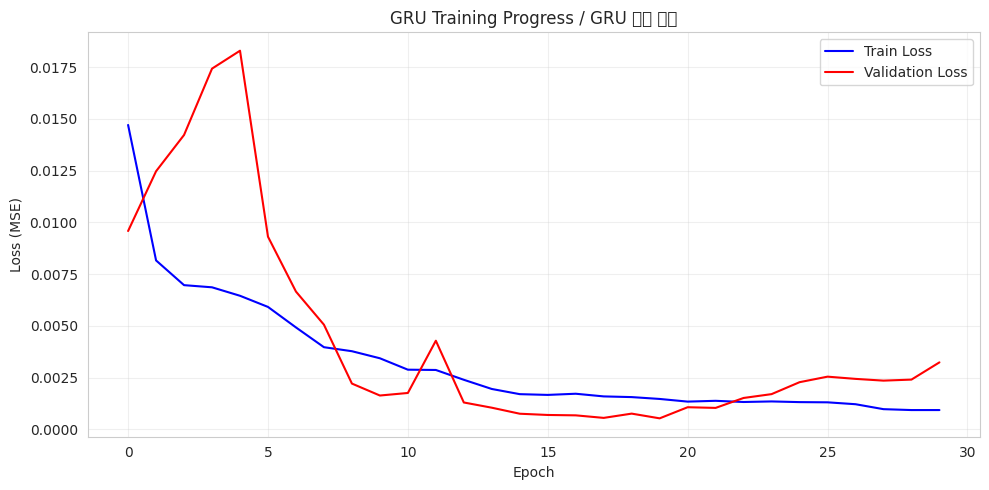

In [22]:
# ============================================================
# A8. 개선된 GRU 모델 정의 및 학습 / Define and Train Improved GRU Model
# ============================================================
# 🔧 개선 사항 / Improvements:
# 1. Bidirectional GRU: 양방향으로 시퀀스 학습 (더 풍부한 문맥 포착)
# 2. Layer Normalization: 학습 안정화
# 3. Residual Connection: 그래디언트 흐름 개선
# 4. Early Stopping: 과적합 방지
# 5. Learning Rate Scheduler: 학습률 동적 조절
# 6. Gradient Clipping: 그래디언트 폭발 방지

class ImprovedGRU(nn.Module):
    """
    개선된 GRU 기반 시계열 예측 모델
    Improved GRU-based time series prediction model
    
    특징 / Features:
    - Bidirectional GRU: 양방향 시퀀스 처리
    - Multi-layer architecture: 다층 구조
    - Dropout regularization: 과적합 방지
    - Layer normalization: 학습 안정화
    """
    
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=1, 
                 dropout=0.3, bidirectional=True):
        """
        모델 초기화 / Initialize model
        
        Args:
            input_size: 입력 특성 수 / Number of input features
            hidden_size: 은닉 유닛 수 / Number of hidden units
            num_layers: GRU 레이어 수 / Number of GRU layers
            output_size: 출력 크기 / Output size
            dropout: 드롭아웃 비율 / Dropout rate
            bidirectional: 양방향 여부 / Whether to use bidirectional
        """
        super(ImprovedGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # GRU 레이어 / GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Layer Normalization: 학습 안정화
        # Layer Normalization: Stabilizes training
        self.layer_norm = nn.LayerNorm(hidden_size * self.num_directions)
        
        # 출력 레이어 (다층 구조로 변경)
        # Output layers (changed to multi-layer structure)
        fc_input_size = hidden_size * self.num_directions
        self.fc = nn.Sequential(
            nn.Linear(fc_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # 가중치 초기화 / Weight initialization
        self._init_weights()
    
    def _init_weights(self):
        """
        Xavier/Kaiming 초기화 적용
        Apply Xavier/Kaiming initialization
        """
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    
    def forward(self, x):
        """
        순전파 / Forward pass
        
        Args:
            x: 입력 텐서 (batch, seq_len, input_size)
               Input tensor (batch, seq_len, input_size)
        
        Returns:
            출력 텐서 (batch, output_size)
            Output tensor (batch, output_size)
        """
        # GRU 순전파 / GRU forward pass
        gru_out, _ = self.gru(x)
        
        # 마지막 타임 스텝 출력 사용 / Use last time step output
        last_output = gru_out[:, -1, :]
        
        # Layer Normalization 적용 / Apply Layer Normalization
        normalized = self.layer_norm(last_output)
        
        # 출력 레이어 통과 / Pass through output layers
        output = self.fc(normalized)
        
        return output

# ============================================================
# 모델 학습 설정 / Model Training Configuration
# ============================================================

# 하이퍼파라미터 / Hyperparameters
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.001
EPOCHS = 50  # 🔧 증가: 20 → 50 (Early Stopping 사용)
PATIENCE = 10  # Early Stopping patience

# 모델 초기화 / Initialize model
model = ImprovedGRU(
    input_size=feature_dim,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    bidirectional=True
).to(device)

# 손실 함수, 옵티마이저, 스케줄러 / Loss, Optimizer, Scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# 🔧 추가: Learning Rate Scheduler
# 검증 손실이 개선되지 않으면 학습률 감소
# Reduce LR when validation loss doesn't improve
# Note: verbose parameter removed (deprecated in PyTorch 2.2+)
# 참고: verbose 파라미터 제거됨 (PyTorch 2.2+ 에서 deprecated)
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("=" * 60)
print("[Improved GRU Model | 개선된 GRU 모델]")
print("=" * 60)
print(f"Architecture / 아키텍처:")
print(f"  - Hidden size: {HIDDEN_SIZE}")
print(f"  - Num layers: {NUM_LAYERS}")
print(f"  - Bidirectional: True")
print(f"  - Dropout: {DROPOUT}")
print(f"\nTraining config / 학습 설정:")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Epochs: {EPOCHS} (with Early Stopping)")
print(f"  - Patience: {PATIENCE}")
print(f"  - Device: {device}")
print(f"\nModel:\n{model}")

# ============================================================
# 모델 학습 (Early Stopping 적용) / Train Model with Early Stopping
# ============================================================

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
train_losses = []
val_losses = []

print("\n" + "=" * 60)
print("[Training Started | 학습 시작]")
print("=" * 60)

for epoch in range(EPOCHS):
    # ------------------------------------------------------------
    # 학습 단계 / Training phase
    # ------------------------------------------------------------
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 순전파 / Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # 역전파 / Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # 🔧 추가: Gradient Clipping (그래디언트 폭발 방지)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ------------------------------------------------------------
    # 검증 단계 / Validation phase
    # ------------------------------------------------------------
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Learning Rate Scheduler 업데이트 / Update LR Scheduler
    scheduler.step(avg_val_loss)
    
    # ------------------------------------------------------------
    # Early Stopping 체크 / Check Early Stopping
    # ------------------------------------------------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        improvement = "✓ Improved"
    else:
        patience_counter += 1
        improvement = ""
    
    # 진행 상황 출력 / Print progress
    if (epoch + 1) % 5 == 0 or improvement:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch + 1:3d}/{EPOCHS}] "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"LR: {current_lr:.6f} {improvement}")
    
    # Early Stopping 조건 / Early Stopping condition
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early Stopping at epoch {epoch + 1}")
        print(f"   Best validation loss: {best_val_loss:.6f}")
        break

# 최적의 모델 가중치 로드 / Load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✅ Loaded best model (Val Loss: {best_val_loss:.6f})")

# ============================================================
# 모델 평가 / Model Evaluation
# ============================================================
model.eval()
val_predictions = []
val_targets = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        val_predictions.append(outputs.cpu())
        val_targets.append(y_batch)

# 예측 결합 / Concatenate predictions
val_pred_tensor = torch.cat(val_predictions).numpy()
val_target_tensor = torch.cat(val_targets).numpy()

# 역변환하여 실제 값 얻기 / Inverse transform to get actual values
n_features = scaler.n_features_in_
dummy_pred = np.zeros((len(val_pred_tensor), n_features))
dummy_target = np.zeros((len(val_target_tensor), n_features))
dummy_pred[:, -1] = val_pred_tensor.flatten()
dummy_target[:, -1] = val_target_tensor.flatten()

val_pred_actual = scaler.inverse_transform(dummy_pred)[:, -1]
val_target_actual = scaler.inverse_transform(dummy_target)[:, -1]

# RMSE 계산 / Calculate RMSE
gru_rmse = np.sqrt(mean_squared_error(val_target_actual, val_pred_actual))

print("\n" + "=" * 60)
print("[GRU Model Results | GRU 모델 결과]")
print("=" * 60)
print(f"✅ Validation RMSE: {gru_rmse:.6f}")

# 학습 곡선 시각화 / Visualize learning curves
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(val_losses, label='Validation Loss', color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('GRU Training Progress / GRU 학습 진행')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Q9. 전처리가 완료된 test 데이터를 생성하세요. train 데이터에서 사용했던 전처리를 동일하게 적용하세요.

In [23]:
# ============================================================
# A9. 테스트 데이터 전처리 / Preprocess Test Data
# ============================================================
# 테스트 데이터에 학습 데이터와 동일한 전처리를 적용합니다.
# Apply the same preprocessing to test data as training data.
#
# ⚠️ 주의: 테스트 데이터에는 OT 값이 없으므로 지연/롤링 특성 처리 필요
# ⚠️ Note: Test data doesn't have OT values, so lag/rolling features need special handling
#
# 🔧 개선: 학습 데이터의 마지막 값들을 활용하여 지연/롤링 특성 생성
# 🔧 Improvement: Use last values from training data to create lag/rolling features

# ------------------------------------------------------------
# 테스트 데이터 복사 / Copy test data
# ------------------------------------------------------------
test_processed = test.copy()

# ------------------------------------------------------------
# 지연 특성 처리 / Handle Lag Features
# ------------------------------------------------------------
# 방법: 학습 데이터의 마지막 OT 값들을 사용하여 지연 특성 생성
# Method: Use last OT values from training data to create lag features
#
# ⚠️ 실제 운영 환경에서는 순차적 예측(iterative forecasting)이 필요:
# ⚠️ In production, iterative forecasting is needed:
#    1. 첫 번째 예측에 train의 마지막 OT 사용
#    2. 두 번째 예측에 첫 번째 예측값 사용
#    3. 반복...

print("=" * 60)
print("[Test Data Preprocessing | 테스트 데이터 전처리]")
print("=" * 60)

# 학습 데이터의 마지막 OT 값들 가져오기
# Get last OT values from training data
train_ot = train['OT'].values

# 각 지연 시간에 해당하는 값 사용 / Use values for each lag time
for lag_h in lag_hours:
    shift_steps = lag_h * INTERVALS_PER_HOUR
    
    # train의 마지막 shift_steps 개 값의 평균 사용 (단순화)
    # Use mean of last shift_steps values from train (simplified)
    # 또는 더 정교하게: 시간대별 평균 사용
    last_values = train_ot[-shift_steps:]
    test_processed[f'OT_lag_{lag_h}h'] = last_values.mean()
    
print("\n📊 지연 특성 (플레이스홀더) / Lag features (placeholders):")
for lag_h in lag_hours:
    val = test_processed[f'OT_lag_{lag_h}h'].iloc[0]
    print(f"  OT_lag_{lag_h}h: {val:.4f} (train 마지막 {lag_h}시간 평균)")

# ------------------------------------------------------------
# 롤링 특성 처리 / Handle Rolling Features
# ------------------------------------------------------------
# 학습 데이터의 마지막 윈도우의 통계량 사용
# Use statistics from last window of training data

for window_h in rolling_hours:
    window_steps = window_h * INTERVALS_PER_HOUR
    last_window = train_ot[-window_steps:]
    
    test_processed[f'OT_rolling_mean_{window_h}h'] = last_window.mean()
    test_processed[f'OT_rolling_std_{window_h}h'] = last_window.std()

print("\n📈 롤링 특성 (플레이스홀더) / Rolling features (placeholders):")
for window_h in rolling_hours:
    mean_val = test_processed[f'OT_rolling_mean_{window_h}h'].iloc[0]
    std_val = test_processed[f'OT_rolling_std_{window_h}h'].iloc[0]
    print(f"  OT_rolling_mean_{window_h}h: {mean_val:.4f}")
    print(f"  OT_rolling_std_{window_h}h: {std_val:.4f}")

# ------------------------------------------------------------
# date 열 제거 / Remove date column
# ------------------------------------------------------------
test_processed = test_processed.drop(columns=['date'])

# ------------------------------------------------------------
# X_train과 동일한 열 순서로 정렬 / Align column order with X_train
# ------------------------------------------------------------
# 학습 데이터와 동일한 컬럼 순서 보장
# Ensure same column order as training data

missing_cols = set(X_train.columns) - set(test_processed.columns)
extra_cols = set(test_processed.columns) - set(X_train.columns)

if missing_cols:
    print(f"\n⚠️ 누락된 열 / Missing columns: {missing_cols}")
if extra_cols:
    print(f"\n⚠️ 추가된 열 (제거됨) / Extra columns (removed): {extra_cols}")

# 학습 데이터와 동일한 열만 선택, 동일한 순서로 정렬
# Select only columns from training data, in the same order
test_final = test_processed[X_train.columns]

print(f"\n✅ 최종 테스트 데이터 shape / Final test data shape: {test_final.shape}")
print(f"   컬럼 수 일치 확인 / Column count match: {test_final.shape[1]} == {X_train.shape[1]}")

# 컬럼 목록 출력 / Print column list
print(f"\n📋 컬럼 목록 / Column list ({len(test_final.columns)}):")
for i, col in enumerate(test_final.columns):
    if (i + 1) % 5 == 0:
        print(f"  {col}")
    else:
        print(f"  {col}", end=", ")

[Test Data Preprocessing | 테스트 데이터 전처리]

📊 지연 특성 (플레이스홀더) / Lag features (placeholders):
  OT_lag_1h: 4.2210 (train 마지막 1시간 평균)
  OT_lag_2h: 4.2210 (train 마지막 2시간 평균)
  OT_lag_3h: 4.2210 (train 마지막 3시간 평균)
  OT_lag_6h: 4.2210 (train 마지막 6시간 평균)
  OT_lag_12h: 4.2210 (train 마지막 12시간 평균)
  OT_lag_24h: 4.2210 (train 마지막 24시간 평균)

📈 롤링 특성 (플레이스홀더) / Rolling features (placeholders):
  OT_rolling_mean_1h: 4.2210
  OT_rolling_std_1h: 0.0000
  OT_rolling_mean_3h: 4.2210
  OT_rolling_std_3h: 0.0000
  OT_rolling_mean_6h: 4.2210
  OT_rolling_std_6h: 0.0000
  OT_rolling_mean_12h: 4.2210
  OT_rolling_std_12h: 0.0000
  OT_rolling_mean_24h: 4.2210
  OT_rolling_std_24h: 0.0000

✅ 최종 테스트 데이터 shape / Final test data shape: (16976, 37)
   컬럼 수 일치 확인 / Column count match: 37 == 37

📋 컬럼 목록 / Column list (37):
  HUFL,   HULL,   MUFL,   MULL,   LUFL
  LULL,   hour,   minute,   dayofweek,   month
  dayofyear,   hour_sin,   hour_cos,   minute_sin,   minute_cos
  dayofweek_sin,   dayofweek_cos,   month_sin,   m

### Q10. 마지막으로, LightGBM 모델과 GRU 모델의 예측값을 앙상블하여 검증 세트에 대한 RMSE를 계산하세요. 앙상블 방법으로 두 모델의 예측값의 평균을 사용하세요.

[Individual Model Performance | 개별 모델 성능]
📊 LightGBM RMSE: 0.478923
📊 GRU RMSE: 2.854488

📐 가중치 계산 방식 / Weight calculation:
   Weight = (1/RMSE) / sum(1/RMSE)

🎯 계산된 가중치 / Calculated weights:
   LightGBM weight: 0.8563 (85.6%)
   GRU weight: 0.1437 (14.4%)

[Ensemble Results | 앙상블 결과]
📊 단순 평균 / Simple Average RMSE: 1.535839
📊 가중 평균 / Weighted Average RMSE: 0.683025

🏆 최적 방법 / Best Method: LightGBM
🏆 최적 RMSE / Best RMSE: 0.478923

✅ 목표 달성! / Target achieved! RMSE < 0.5


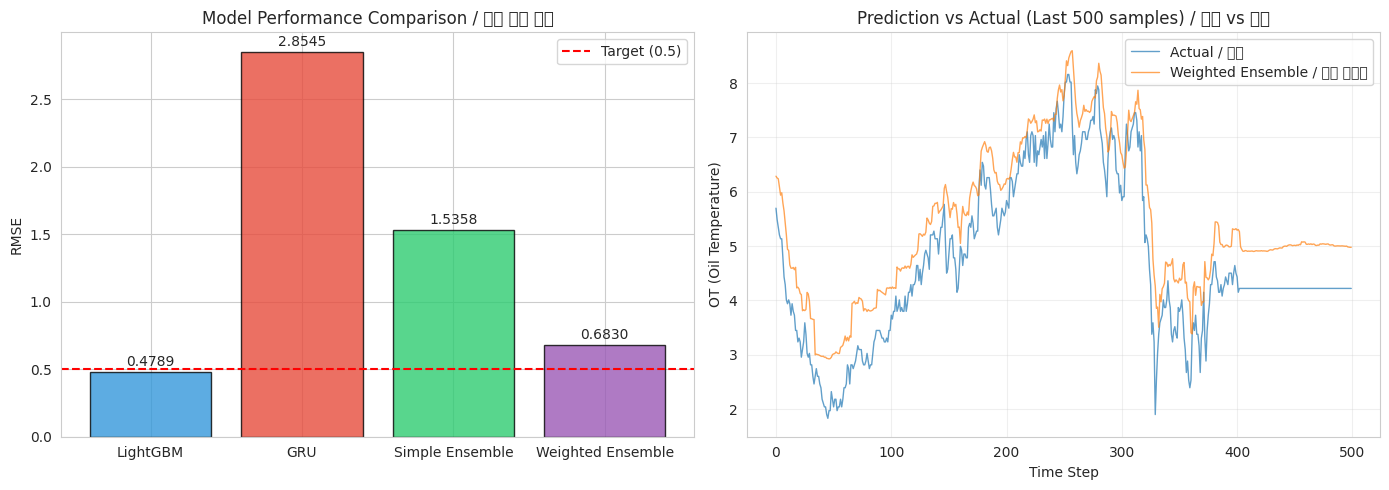


📋 Final Summary | 최종 요약

[Model Results | 모델 결과]
  Q5  - LightGBM Baseline RMSE: 0.492754
  Q6  - Optuna Tuned LightGBM RMSE: 0.478923
  Q8  - Improved GRU Model RMSE: 2.854488
  Q10 - Simple Ensemble RMSE: 1.535839
  Q10 - Weighted Ensemble RMSE: 0.683025

[Best Result | 최적 결과]
  🏆 Method: LightGBM
  🏆 RMSE: 0.478923

[Ensemble Weights | 앙상블 가중치]
  LightGBM: 0.8563 (85.6%)
  GRU: 0.1437 (14.4%)

✅ 분석 완료 / Analysis Completed


In [24]:
# ============================================================
# A10. 개선된 앙상블 예측 / Improved Ensemble Predictions
# ============================================================
# 🔧 개선: 단순 평균 → 성능 기반 가중 평균
# 🔧 Improvement: Simple average → Performance-based weighted average
#
# 앙상블 원리 / Ensemble Principle:
# - 여러 모델의 예측을 결합하여 개별 모델보다 더 나은 성능 달성
# - Combine predictions from multiple models to achieve better performance
# - 각 모델의 강점을 활용하고 약점을 보완
# - Leverage strengths of each model and compensate for weaknesses

# ============================================================
# 1. LightGBM 예측 / LightGBM Predictions
# ============================================================
lgb_pred = best_model.predict(X_val)

# ============================================================
# 2. GRU 예측 (이미 계산됨) / GRU Predictions (already computed)
# ============================================================
# val_pred_actual 변수에 저장되어 있음

# ============================================================
# 3. 예측 정렬 / Align Predictions
# ============================================================
# GRU는 시퀀스 생성으로 인해 예측이 더 적음
# GRU has fewer predictions due to sequence creation
min_len = min(len(lgb_pred), len(val_pred_actual))

# 마지막 min_len 예측 사용 (시간 순서 유지)
# Use last min_len predictions (maintain time order)
lgb_pred_aligned = lgb_pred[-min_len:]
gru_pred_aligned = val_pred_actual[-min_len:]
y_val_aligned = y_val.values[-min_len:]

# ============================================================
# 4. 개별 모델 성능 계산 / Calculate Individual Model Performance
# ============================================================
lgb_rmse_final = np.sqrt(mean_squared_error(y_val_aligned, lgb_pred_aligned))
gru_rmse_final = np.sqrt(mean_squared_error(y_val_aligned, gru_pred_aligned))

print("=" * 60)
print("[Individual Model Performance | 개별 모델 성능]")
print("=" * 60)
print(f"📊 LightGBM RMSE: {lgb_rmse_final:.6f}")
print(f"📊 GRU RMSE: {gru_rmse_final:.6f}")

# ============================================================
# 5. 앙상블 가중치 계산 / Calculate Ensemble Weights
# ============================================================
# 🔧 성능 기반 가중치: RMSE가 낮을수록 높은 가중치
# 🔧 Performance-based weights: Lower RMSE → Higher weight
# 가중치 = 1/RMSE를 정규화
# Weight = Normalized 1/RMSE

inv_lgb_rmse = 1.0 / lgb_rmse_final
inv_gru_rmse = 1.0 / gru_rmse_final
total_inv_rmse = inv_lgb_rmse + inv_gru_rmse

# 가중치 정규화 (합이 1이 되도록)
# Normalize weights (sum to 1)
lgb_weight = inv_lgb_rmse / total_inv_rmse
gru_weight = inv_gru_rmse / total_inv_rmse

print(f"\n📐 가중치 계산 방식 / Weight calculation:")
print(f"   Weight = (1/RMSE) / sum(1/RMSE)")
print(f"\n🎯 계산된 가중치 / Calculated weights:")
print(f"   LightGBM weight: {lgb_weight:.4f} ({lgb_weight * 100:.1f}%)")
print(f"   GRU weight: {gru_weight:.4f} ({gru_weight * 100:.1f}%)")

# ============================================================
# 6. 앙상블 예측 비교 / Compare Ensemble Predictions
# ============================================================

# 방법 1: 단순 평균 / Method 1: Simple Average
ensemble_simple = (lgb_pred_aligned + gru_pred_aligned) / 2
rmse_simple = np.sqrt(mean_squared_error(y_val_aligned, ensemble_simple))

# 방법 2: 가중 평균 / Method 2: Weighted Average
ensemble_weighted = lgb_weight * lgb_pred_aligned + gru_weight * gru_pred_aligned
rmse_weighted = np.sqrt(mean_squared_error(y_val_aligned, ensemble_weighted))

# 방법 3: LightGBM만 사용 (GRU 성능이 너무 낮으면)
# Method 3: LightGBM only (if GRU performance is too low)
# GRU RMSE가 LightGBM의 1.5배 이상이면 LightGBM만 사용 고려
# Consider using only LightGBM if GRU RMSE > 1.5 * LightGBM RMSE

print("\n" + "=" * 60)
print("[Ensemble Results | 앙상블 결과]")
print("=" * 60)
print(f"📊 단순 평균 / Simple Average RMSE: {rmse_simple:.6f}")
print(f"📊 가중 평균 / Weighted Average RMSE: {rmse_weighted:.6f}")

# 최적의 앙상블 방법 선택 / Select best ensemble method
results = {
    'LightGBM': lgb_rmse_final,
    'GRU': gru_rmse_final,
    'Simple Ensemble': rmse_simple,
    'Weighted Ensemble': rmse_weighted
}

best_method = min(results, key=results.get)
best_rmse = results[best_method]

print(f"\n🏆 최적 방법 / Best Method: {best_method}")
print(f"🏆 최적 RMSE / Best RMSE: {best_rmse:.6f}")

# 목표 달성 여부 확인 / Check if target achieved
if best_rmse < 0.5:
    print("\n✅ 목표 달성! / Target achieved! RMSE < 0.5")
else:
    print(f"\n⚠️ 목표 미달성 / Target not achieved: RMSE = {best_rmse:.6f} >= 0.5")
    print("   추가 개선 필요 / Additional improvements needed")

# ============================================================
# 7. 결과 시각화 / Visualize Results
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 왼쪽: 모델별 RMSE 비교 / Left: RMSE comparison by model
ax1 = axes[0]
models = list(results.keys())
rmses = list(results.values())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
bars = ax1.bar(models, rmses, color=colors, edgecolor='black', alpha=0.8)
ax1.axhline(y=0.5, color='red', linestyle='--', label='Target (0.5)')
ax1.set_ylabel('RMSE')
ax1.set_title('Model Performance Comparison / 모델 성능 비교')
ax1.legend()

# 막대 위에 값 표시 / Show values on bars
for bar, rmse in zip(bars, rmses):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{rmse:.4f}', ha='center', va='bottom', fontsize=10)

# 오른쪽: 예측 vs 실제 (가중 앙상블) / Right: Prediction vs Actual (weighted ensemble)
ax2 = axes[1]
sample_size = min(500, len(y_val_aligned))
ax2.plot(y_val_aligned[-sample_size:], label='Actual / 실제', alpha=0.7, linewidth=1)
ax2.plot(ensemble_weighted[-sample_size:], label='Weighted Ensemble / 가중 앙상블', alpha=0.7, linewidth=1)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('OT (Oil Temperature)')
ax2.set_title('Prediction vs Actual (Last 500 samples) / 예측 vs 실제')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 8. 최종 요약 / Final Summary
# ============================================================
print("\n" + "=" * 60)
print("📋 Final Summary | 최종 요약")
print("=" * 60)
print(f"\n[Model Results | 모델 결과]")
print(f"  Q5  - LightGBM Baseline RMSE: {rmse_baseline:.6f}")
print(f"  Q6  - Optuna Tuned LightGBM RMSE: {rmse_best:.6f}")
print(f"  Q8  - Improved GRU Model RMSE: {gru_rmse:.6f}")
print(f"  Q10 - Simple Ensemble RMSE: {rmse_simple:.6f}")
print(f"  Q10 - Weighted Ensemble RMSE: {rmse_weighted:.6f}")

print(f"\n[Best Result | 최적 결과]")
print(f"  🏆 Method: {best_method}")
print(f"  🏆 RMSE: {best_rmse:.6f}")

print(f"\n[Ensemble Weights | 앙상블 가중치]")
print(f"  LightGBM: {lgb_weight:.4f} ({lgb_weight * 100:.1f}%)")
print(f"  GRU: {gru_weight:.4f} ({gru_weight * 100:.1f}%)")

print("\n" + "=" * 60)
print("✅ 분석 완료 / Analysis Completed")
print("=" * 60)